# Take a look of data

Many thanks for Radek's starter guide

https://github.com/radekosmulski/rsna-intracranial

In [1]:
# uncomment this line if don't have pydicom
#!pip install pydicom

In [1]:
%matplotlib inline

import PIL
import pydicom
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import fastai
from fastai.core import parallel

In [5]:
torch.__version__, fastai.__version__

('1.2.0', '1.0.58')

In [6]:
!pwd

/home/jupyter/rsns


In [2]:
path = Path('/home/jupyter/rsns/data/raw/')
path.ls()

[PosixPath('/home/jupyter/rsns/data/raw/stage_1_sample_submission.csv.zip'),
 PosixPath('/home/jupyter/rsns/data/raw/stage_1_train.csv.zip'),
 PosixPath('/home/jupyter/rsns/data/raw/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/rsns/data/raw/stage_1_train.csv'),
 PosixPath('/home/jupyter/rsns/data/raw/stage_1_sample_submission.csv'),
 PosixPath('/home/jupyter/rsns/data/raw/rsna-intracranial-hemorrhage-detection.zip')]

In [3]:
#takes couple hours to finish
#!unzip -q -o {path}/rsna-intracranial-hemorrhage-detection.zip -d {path}

In [5]:
!ls {path}/stage_1_train_images | head -10

ID_000039fa0.dcm
ID_00005679d.dcm
ID_00008ce3c.dcm
ID_0000950d7.dcm
ID_0000aee4b.dcm
ID_0000f1657.dcm
ID_000178e76.dcm
ID_00019828f.dcm
ID_0001dcc25.dcm
ID_0001de0e8.dcm
ls: write error: Broken pipe


In [6]:
path = path/'stage_1_train_images'
one_file = path.ls()[0]

In [7]:
one_file

PosixPath('/home/jupyter/rsns/data/raw/stage_1_train_images/ID_4c995fb13.dcm')

In [8]:
im = pydicom.read_file(str(one_file))

In [14]:
im

(0008, 0018) SOP Instance UID                    UI: ID_4c995fb13
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_7d3d32cf'
(0020, 000d) Study Instance UID                  UI: ID_2d49a3e4a3
(0020, 000e) Series Instance UID                 UI: ID_6a2dab02f4
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '3.02994322', '213.968705']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '0.956304756', '-0.292371705']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         U

In [17]:
im.keys()

dict_keys([(0008, 0018), (0008, 0060), (0010, 0020), (0020, 000d), (0020, 000e), (0020, 0010), (0020, 0032), (0020, 0037), (0028, 0002), (0028, 0004), (0028, 0010), (0028, 0011), (0028, 0030), (0028, 0100), (0028, 0101), (0028, 0102), (0028, 0103), (0028, 1050), (0028, 1051), (0028, 1052), (0028, 1053), (7fe0, 0010)])

In [35]:
im[('0028','0103')], im[('0028','0103')].value

((0028, 0103) Pixel Representation                US: 0, 0)

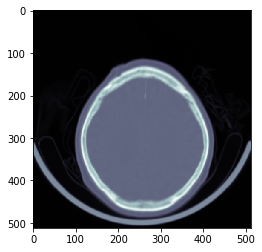

In [22]:
plt.imshow(im.pixel_array,cmap=plt.cm.bone)

In [24]:
im.pixel_array.shape

(512, 512)

# HC unit for CT scan

Based on Kaggle community discussion, radiologist use HC unit for CT images. Let's try using the window size suggested by radiologist


In [27]:
window_center = 40
window_width = 80
def window_and_normalize(im):
    rescaled = im.pixel_array * float(im.RescaleSlope) + float(im.RescaleIntercept)
    windowed = rescaled.clip(min=window_center-window_width, max=window_center+window_width)

    return (windowed + np.negative(window_center-window_width)) / (window_width * 2 * 1/255)

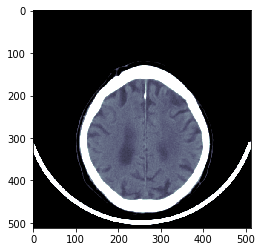

In [28]:
plt.imshow(window_and_normalize(im),cmap=plt.cm.bone)

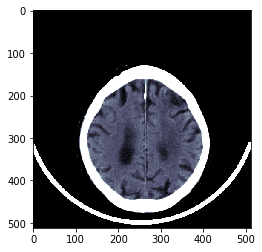

In [32]:
#suggested by radiologist
window_width = 80//2
plt.imshow(window_and_normalize(im),cmap=plt.cm.bone)

In [36]:
path

PosixPath('/home/jupyter/rsns/data/raw/stage_1_train_images')

In [37]:
!mkdir /home/jupyter/rsns/data/raw/128
!mkdir /home/jupyter/rsns/data/raw/128/train
!mkdir /home/jupyter/rsns/data/raw/128/test

In [38]:
def resize(src, dst, sz):
    im = pydicom.read_file(str(src))
    ary = window_and_normalize(im)
    im = PIL.Image.fromarray(ary.astype(np.int8), mode='L')
    im.resize((sz,sz), resample=PIL.Image.BICUBIC).save(f'{dst}/{src.stem}.png')

In [39]:
def _resize_128(path,_):
    resize(path,'/home/jupyter/rsns/data/raw/128/train',128)

In [40]:
parallel(_resize_128,path.ls(),max_workers=4)

KeyboardInterrupt: 